### Tutorial: Radon Signed Cumulative Distribution Transform (RSCDT)



In [1]:
!pip install --upgrade pytranskit

## Definition


**Forward Transform**
Let $r : \mathbb{R}^2 \rightarrow \mathbb{R}$ be the reference image and $s : \mathbb{R}^2 \rightarrow \mathbb{R}$ be the target image. The forward transform RSCDT of $s$ with respect to $r$ for each $\theta \in [0,\pi]$ is given as,
\begin{equation}
    \widehat{s}(\cdot, \theta) =  \mathbb{T}_{\tilde{r}(\cdot,\theta)}(\tilde{s}(\cdot,\theta)) = \Big(({\widetilde{s}}^+)^\star(\cdot, \theta), \|{\widetilde{s}}^+(\cdot,\theta)\|_1, ({\widetilde{s}}^-)^\star(\cdot, \theta), \|{\widetilde{s}}^-(\cdot, \theta)\|_1\Big)
\end{equation}

where $\widetilde{r}(t,\theta) = \mathcal{R}(r(\textbf{x}))  \text{ and }  \widetilde{s}(t,\theta) = \mathcal{R}(s(\textbf{x}))$ are the Radon transform of $r$ and $s$ respectively. The Radon transform of an image $s$ is given as,
\begin{equation}
    \widetilde{s}(t,\theta) = \int_{\Omega_s}s(\textbf{x})\delta(t-\textbf{x}\cdot{\xi}_\theta)d\textbf{x}, \quad \xi_\theta = [\cos(\theta),\sin(\theta)]^T
\end{equation}


**Inverse Transform**  A transformed image in the RSCDT space can be recovered via following inverse formula,
\begin{equation}
s = \mathcal{R}^{-1} ([\mathbb{T}^{-1}_{\widetilde{r}(\cdot,\theta)}(\widehat{s}(\cdot,\theta))]_{\theta \in [0,\pi]})
\end{equation}


where $\mathcal{R}^{-1}$ is the inverse of the Radon transform and $\mathbb{T}^{-1}$ is the inverse of the SCDT. Specifically,
\begin{equation}
\mathcal{R}^{-1}(\widetilde{s})(\mathbf{x}) =\int_0^\pi\int_{-\infty}^{\infty}\widetilde{s}(\mathbf{x}\cdot\xi_\theta-\tau,\theta)w(\tau)d\tau d\theta = s(\mathbf{x})
\end{equation}
 and
\begin{equation} \label{SCDT_inv}
    \mathbb{T}^{-1}(f(t),u,g(t),v) = \frac{u}{\|r\|_1} r(f^{\dagger}(t)) (f^{\dagger})'(t) - \frac{v}{\|r\|_1} r(g^{\dagger}(t)) (g^{\dagger})'(t)
\end{equation}



# Implementation of forward and inverse transform

In [2]:
import numpy as np
import random
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
#matplotlib inline
import imageio as iio
import sys
sys.path.append('../')
from pytranskit.optrans.continuous.radonscdt import RadonSCDT

from sklearn.metrics import accuracy_score
from pathlib import Path
from pytranskit.classification.utils import *

use_gpu = False
from pytranskit.classification.RSCDT_NS import RSCDT_NS

Text(0.5, 1.0, 'Reconstructed image')

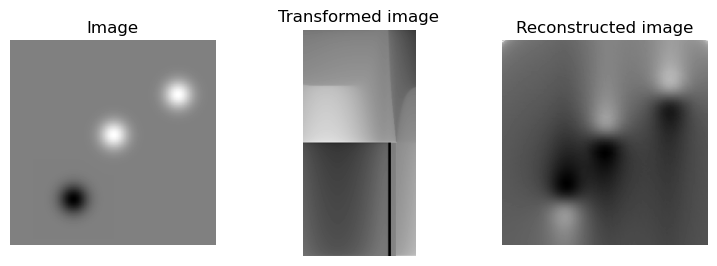

In [3]:
## Generating a Sample image consists of positive and negative pixel values

Img = np.zeros([128,128])
x0=random.randint(40,80)
y0=random.randint(40,80)

Img[x0,y0] = 1
Img[x0+40,y0-25] = -1
Img[x0-25,y0+40] = 1

Img = gaussian_filter(Img, sigma=random.randint(3,6))
Img=np.asarray(Img,dtype=np.float64)
template=np.ones_like(Img)
x0_range = [0, 1]
x_range = [0, 1]
fig,(ax)=plt.subplots(ncols=3,dpi=100,figsize=(9,3))
im=ax[0].imshow(Img,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Image')
## RSCDT  Forward Transform
RSCDT=RadonSCDT()
RSCDT_img,ref,mpos_all,mneg_all,rad1=RSCDT.forward( x0_range, template, x_range, Img, rm_edge=False)
im=ax[1].imshow(RSCDT_img,cmap='gray')
ax[1].axis('off')
ax[1].set_title('Transformed image')

## Reconstruction: RSCDT Inverse Transform 
Irec,rdn=RSCDT.inverse( RSCDT_img,ref,mpos_all,mneg_all, template, x_range)
im=ax[2].imshow(Irec,cmap='gray')
ax[2].axis('off')
ax[2].set_title('Reconstructed image')


# RSCDT based nearest subspace method for image classification

In [4]:
# Data generation for image classification
im_no=20 # no. of images per class
X=[]
Y=[]
# Generating images for Class 1
for i in range(im_no):
    I0=[];I=[]
    I0 = np.zeros([128,128])
    x0=random.randint(40,80)
    y0=random.randint(40,80)

    I0[x0,y0] = 1
    I0[x0+40,y0-25] = -1
    I0[x0-25,y0+40] = 1

    I0 = gaussian_filter(I0, sigma=random.randint(5,15))
    I0=np.asarray(I0,dtype=np.float64)
    # Perform transform
    #########################################################################
    ## Try radon SCDT

    I=I0
    x0_range = [0, 1]
    x_range = [0, 1]
    template=np.ones([128, 128])
    radonscdt = RadonSCDT()
    Ihat,ref,mpos,mneg,rad1= radonscdt.forward(x0_range, template, x_range, I)

    X.append(I0)
    print(np.asarray(X).shape)
    Y.append(np.array([0]))

## Generating images for class 2
for i in range(im_no):
    I0=[];I=[]
    I0 = np.zeros([128,128])
    x0=random.randint(40,80)
    y0=random.randint(40,80)

    I0[x0,y0] = 1
    I0[x0+40,y0-25] = -1
    I0[x0-25,y0+40] = -1
    I0 = gaussian_filter(I0, sigma=random.randint(5,15))
    I0=np.asarray(I0,dtype=np.float64)
    # Perform transform
    #########################################################################

    I=I0
    x0_range = [0, 1]
    x_range = [0, 1]
    template=np.ones([128, 128])
    radonscdt = RadonSCDT()
    Ihat,ref,mpos,mneg,rad1= radonscdt.forward(x0_range, template, x_range, I)
    X.append(I0)
    print(np.asarray(X).shape)
    Y.append(np.array([1]))

X=np.asarray(X)
Y=np.asarray(Y).ravel().T


(1, 128, 128)
(2, 128, 128)
(3, 128, 128)
(4, 128, 128)
(5, 128, 128)
(6, 128, 128)
(7, 128, 128)
(8, 128, 128)
(9, 128, 128)
(10, 128, 128)
(11, 128, 128)
(12, 128, 128)
(13, 128, 128)
(14, 128, 128)
(15, 128, 128)
(16, 128, 128)
(17, 128, 128)
(18, 128, 128)
(19, 128, 128)
(20, 128, 128)
(21, 128, 128)
(22, 128, 128)
(23, 128, 128)
(24, 128, 128)
(25, 128, 128)
(26, 128, 128)
(27, 128, 128)
(28, 128, 128)
(29, 128, 128)
(30, 128, 128)
(31, 128, 128)
(32, 128, 128)
(33, 128, 128)
(34, 128, 128)
(35, 128, 128)
(36, 128, 128)
(37, 128, 128)
(38, 128, 128)
(39, 128, 128)
(40, 128, 128)


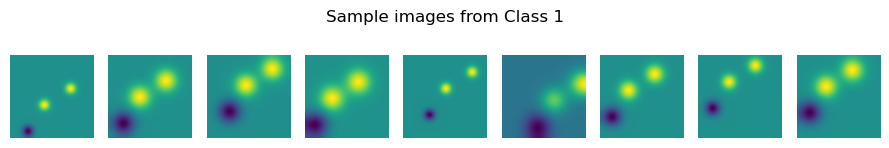

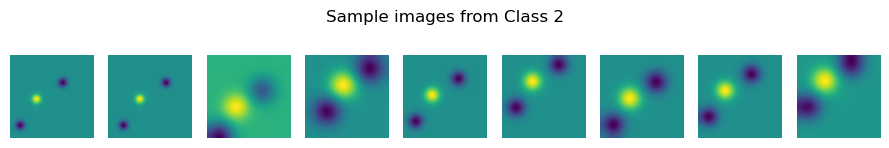

In [5]:
# Sample images from class 1
fig,(ax)=plt.subplots(ncols=9,dpi=100,figsize=(9,1.5))
fig.suptitle('Sample images from Class 1')

for i in range(9):
    im=ax[i].imshow(X[i,:,:],cmap='viridis')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

# Sample images from class 2
fig,(ax)=plt.subplots(ncols=9,dpi=100,figsize=(9,1.5))
fig.suptitle('Sample images from Class 2')

for i in range(9):
    ax[i].imshow(X[im_no+i,:,:],cmap='viridis')
    ax[i].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# Classification
X=np.asarray(X)
Y=np.asarray(Y).ravel().T

num_classes=2
n_samples_perclass = im_no # total number of training samples per class used in this example
x_train_sub, y_train_sub = take_train_samples(X, Y, n_samples_perclass,
                                              num_classes, repeat=0) # function from utils.py
data_train, data_test, label_train, label_test = train_test_split(X, Y, test_size=0.5, random_state=42)


theta = np.linspace(0, 176, 45)    # choose the angles in degrees that will be used to calculate Radon projections
rscdt_ns_obj = RSCDT_NS(num_classes, theta, rm_edge=True)

rscdt_ns_obj.fit(data_train,label_train)
preds = rscdt_ns_obj.predict(data_test, use_gpu)
print('\nTest accuracy: {}%'.format(100*accuracy_score(label_test, preds)))



Calculating RSCDTs for training images ...
Generating basis vectors for each class ...

Calculating RSCDTs for testing images ...


## Reference

Gong, L., Li, S., Pathan, N. S., Rohde, G. K., Rubaiyat, A. H. M., & Thareja, S. (2023). 
"The Radon Signed Cumulative Distribution Transform and its applications in classification of Signed Images."
arXiv preprint arXiv:2307.15339. 